In [1]:
################
# Ellis Ward
# Mark Petersen
# August 2022
################
import numpy as np
import matplotlib.pyplot as plt
"""
Uses an fft to find the phase of the frequency with the highest power
The higher the sampling rate, the higher the precision
Params:
data -- time series to be converted to a power spectrum
sampling_rate -- how many samples are taken per unit time
returns: phase round to three decimal places
"""
def spectrumAngle(data, sampling_rate):
    real_fourier_transform = np.fft.rfft(data)
    abs_fourier_transform = np.abs(real_fourier_transform)
    # equivalent np.fft.rfftfreq(len(data), d=1/sampling_rate)
    frequency = np.linspace(0, sampling_rate/2, len(abs_fourier_transform))
    max_index = np.argmax(abs_fourier_transform)
    angles = np.angle(real_fourier_transform)
    phase = angles[max_index]
    return np.round(phase,decimals=3)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
"""
Creates a power spectrum in frequency space given data in the time domain and finds the frequency with the highest power.
The higher the sampling rate, the higher the precision
Params:
data -- time series to be converted to a power spectrum
sampling_rate -- how many samples are taken per unit time
cutoff -- the starting index from which the frequency array should be searched for the max frequency. 
0 searches the whole list, default is 0

returns: a triplet containing the array of the power spectrum, the array of the frequencies, and the max frequency calculated
"""
def powerspectrum(data, sampling_rate, cutoff=0):
    real_fourier_transform = np.fft.rfft(data)
    abs_fourier_transform = np.abs(real_fourier_transform)
    powerspectrum = np.square(abs_fourier_transform)
    # equivalent np.fft.rfftfreq(len(data), d=1/sampling_rate)
    frequency = np.linspace(0, sampling_rate/2, len(powerspectrum))
    max_index = np.argmax(powerspectrum[cutoff:])
    max_frequency = frequency[cutoff:][max_index]
    return (powerspectrum, frequency, max_frequency)

/var/folders/5_/996nkcg97t1435pt9dwngns40000gs/T/ipykernel_21231/3186713987.py:101: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("seismic").copy()
  current_cmap.set_bad(color='grey')


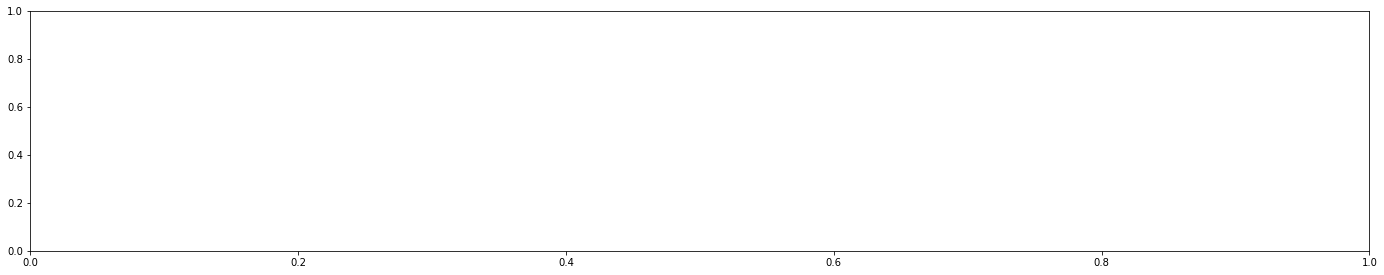

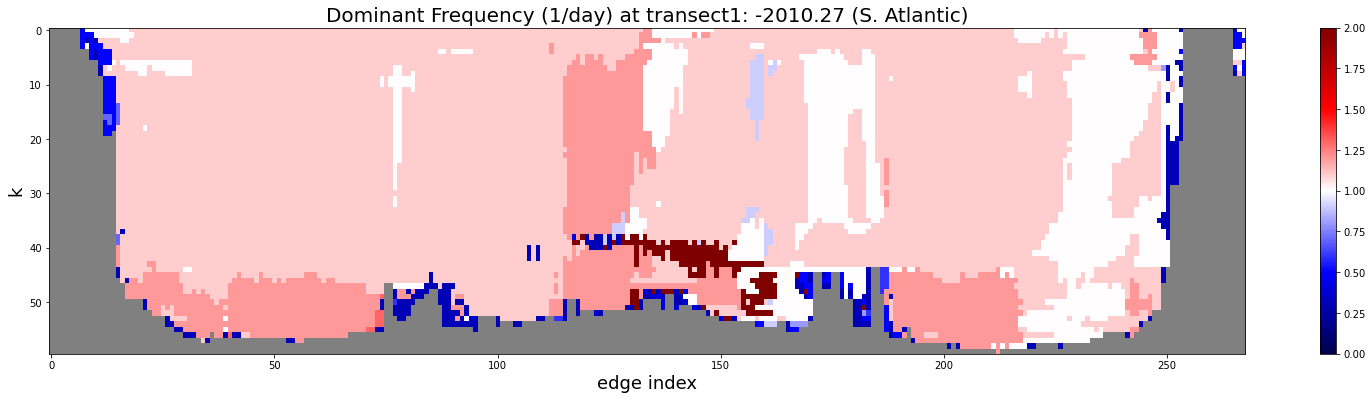

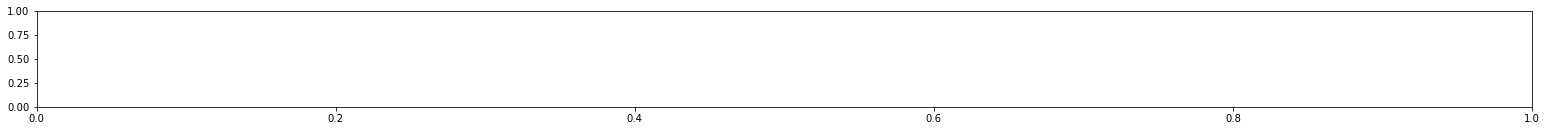

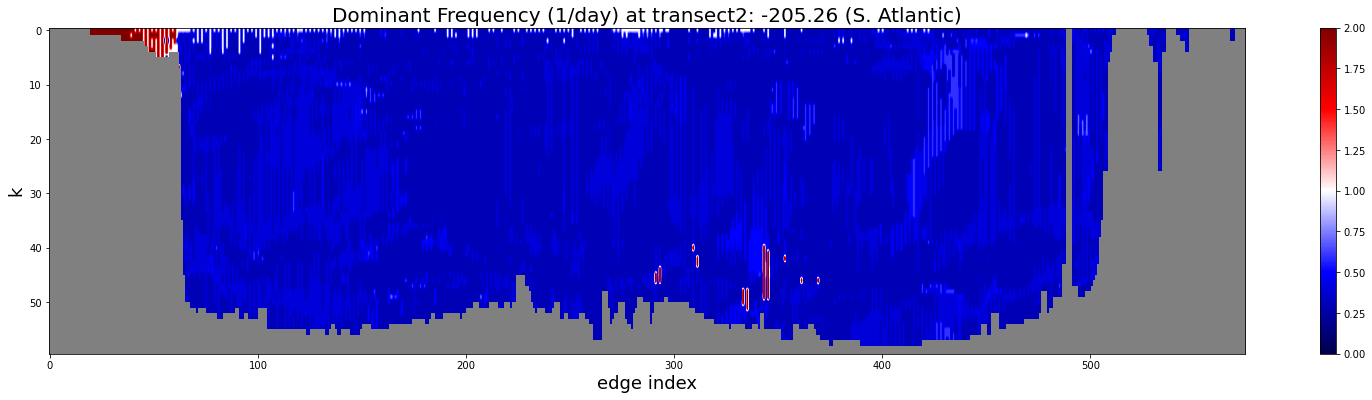

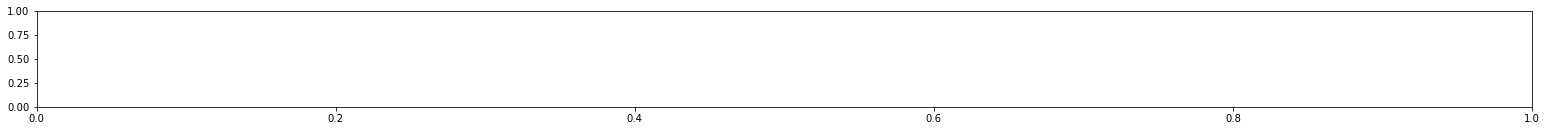

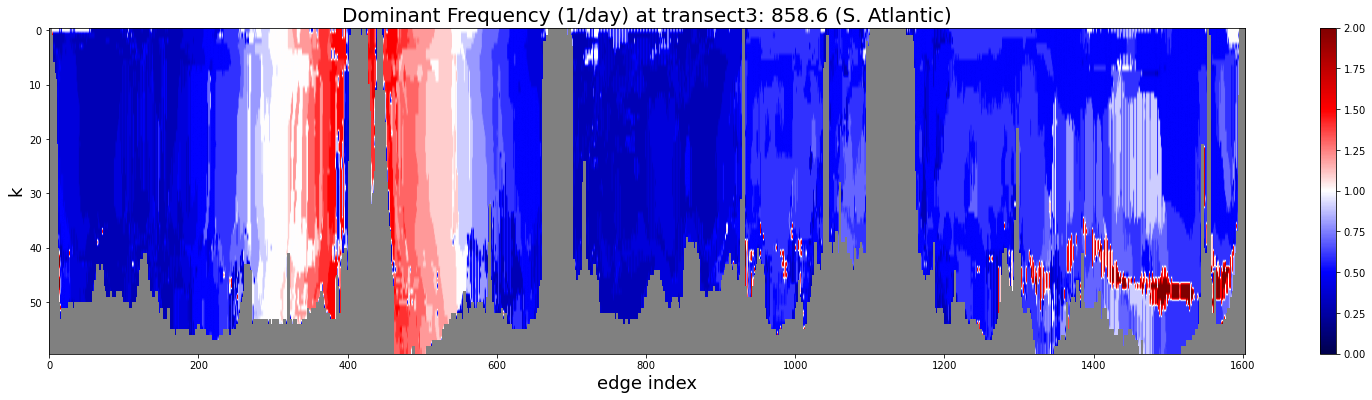

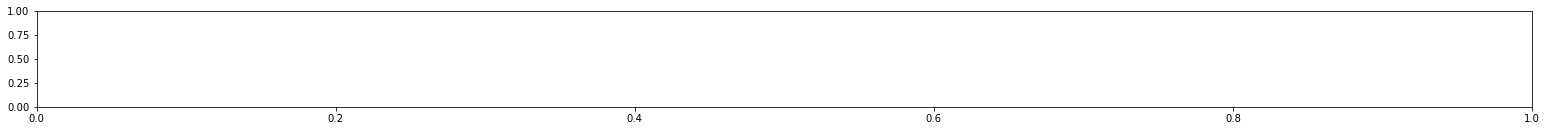

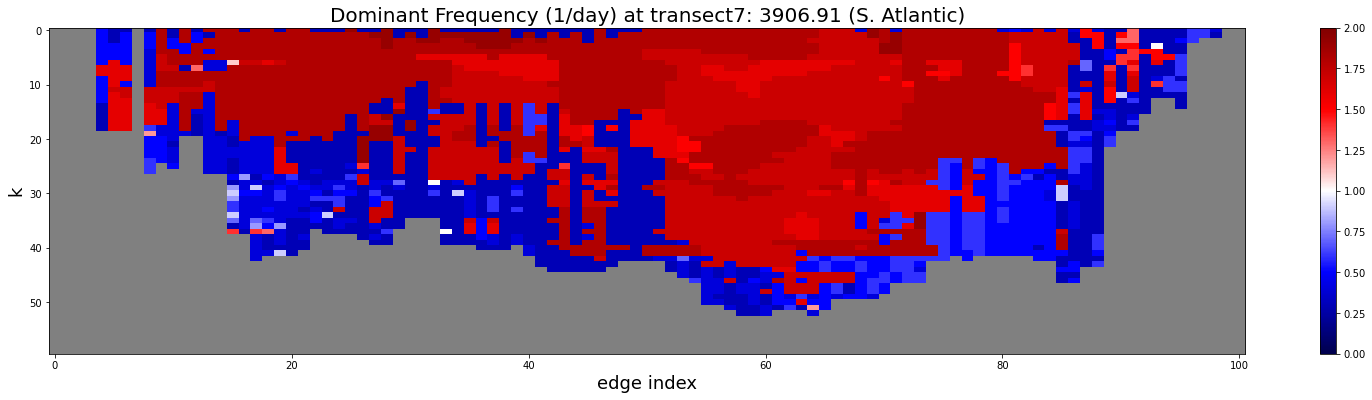

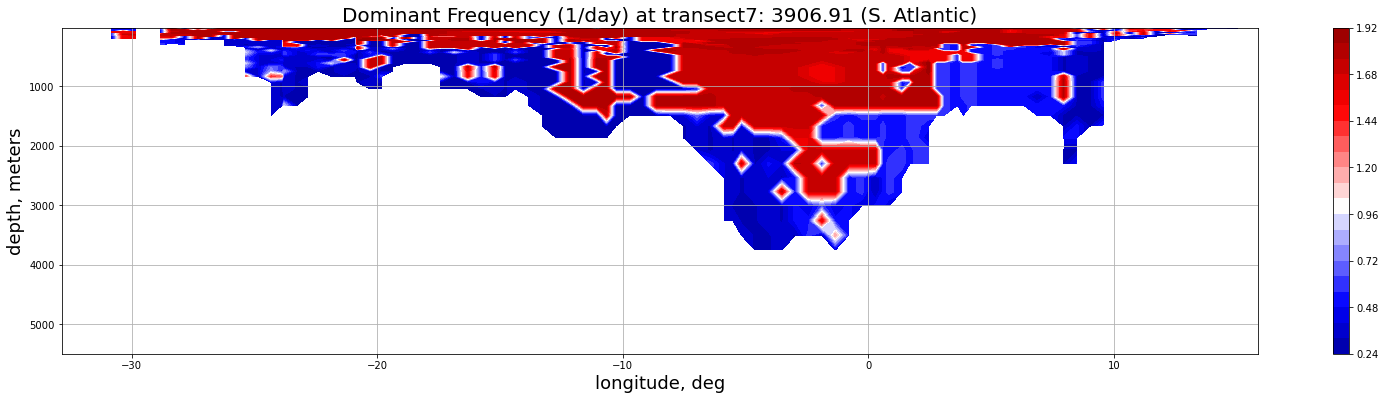

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import time
time0 = time.perf_counter()

files = ['mpasoData/section_lat34.5S_10day.pkl','mpasoData/outSectionTr2_time_239.pkl','mpasoData/outSectionTr3_time_239.pkl','mpasoData/outSectionTr7_time_239.pkl']
transectNum = [1,2,3,7]
for (file,i) in zip(files,transectNum):
    # extract variables from picke file
    fh = open(file,'rb')
    [daysSinceStartOfSim,
            dvEdge,latEdge,lonEdge,edgeSign,
            normalVelocityEdge,
            latCell,lonCell,maxLevelCell,
            velocityZonalCell,velocityMeridionalCell,vertVelocityTopCell,layerThicknessCell,
            refBottomDepth, h
            ]= pickle.load(fh)

    # size of variables
    nTime = np.size(normalVelocityEdge,0)
    nVertLevels = np.size(normalVelocityEdge,2)
    nEdges = len(latEdge)
    nCells = len(latCell)
    
    # unit conversions
    d2r=np.pi/180.
    r2d=180./np.pi
    m3ps_to_Sv = 1e-6 # m^3/sec flux to Sverdrups
    lonEdge = np.mod(lonEdge*r2d+180,360)-180
    latEdge = latEdge*r2d
    lonCell = np.mod(lonCell*r2d+180,360)-180
    latCell = latCell*r2d
    time = daysSinceStartOfSim[:nTime] - daysSinceStartOfSim[0]
    mpl.rcParams['figure.figsize'] = (24,15) # Large figures
    latText = f'transect{i}: {np.round(latCell[0-5]*r2d,2)}'

    # Compute the transport
    nTransects = 1
    transport = np.zeros((nTime, nTransects))
    transportZ = np.zeros((nTime, nTransects, nVertLevels))
    for iTime in range(nTime):
        for k in range(nVertLevels):
            # negative for southward flow
            transportZ[iTime,0,k] = -(dvEdge[:]*h[k]*normalVelocityEdge[iTime,:,k]*edgeSign[:]*m3ps_to_Sv).sum()
        transport[iTime,0] = transportZ[iTime,:].sum()
    # plot cell and edge locations on map

    
    iEdge = np.arange(0,nEdges)
    iCell = np.arange(0,nCells)
    plt.subplot(3,1,1)
    # correct for north or south direction
    velSigned = normalVelocityEdge
    for iTime in range(nTime):
        for k in range(nVertLevels):
            velSigned[iTime,:,k] = normalVelocityEdge[iTime,:,k]*edgeSign[:]
    
    # compute frequency, angle, and correlation array 
    # latitude of the transect in rads
    rad = latCell[0-5]
    # ideal signal
    ideal_freq = 2*np.sin(rad)
    ideal_time = np.arange(0, 10, 1/24)
    idealized_signal = np.sin(2*np.pi*ideal_freq*ideal_time)
    
    frequencies_k = []
    angles_k = []
    correlation_k = []
    for k in range(nVertLevels):
        frequencies_e = []
        angles_e = []
        correlation_e = []
        for edge in range(nEdges):
            data = velSigned[:,edge,k]
            # filter out values where all velocities are zero
            if max(abs(velSigned[:,edge, k])) == 0:
                frequencies_e.append(np.NaN)
                angles_e.append(np.NaN)
                correlation_e.append(np.NaN)
            else:
                (power_spectrum, frequency, max_frequency) = powerspectrum(data, 24, cutoff=3)
                angle = spectrumAngle(data,24)
                # calcuate the correlation with the idealized signal
                correlation = float(np.corrcoef(data,idealized_signal)[0,1])
                frequencies_e.append(max_frequency)
                angles_e.append(angle)
                correlation_e.append(correlation)
        frequencies_k.append(frequencies_e)
        angles_k.append(angles_e)
        correlation_k.append(correlation_e)
    freq_arr = frequencies_k
    angle_arr = angles_k
    correlation_arr = correlation_k

    # imshow array, k vs. edge index showing dominant frequency
    mpl.rcParams['image.cmap'] = 'seismic'
    f = plt.figure(figsize=(26.8,6))
    current_cmap = plt.cm.get_cmap()
    current_cmap.set_bad(color='grey')
    im = plt.imshow(freq_arr, cmap = current_cmap,aspect='auto', vmin =0.0, vmax=2.0)
    f.colorbar(im)
    plt.title(f'Dominant Frequency (1/day) at {latText} (S. Atlantic)',fontsize=20)
    plt.ylabel('k',fontsize=18)
    plt.xlabel('edge index',fontsize=18)
    plt.savefig('DominantFrequencyArrayat34.5SS.Atlantic.png')
    
    # contour plot, depth vs. longitude showing dominat frequency
    figure,ax = plt.subplots(figsize=(26.8,6))
    plot = ax.contourf(lonEdge,refBottomDepth, freq_arr, 21, vmin = 0.0, vmax = 2.0,)
    figure.colorbar(plot)
    ax.set_title(f'Dominant Frequency (1/day) at {latText} (S. Atlantic)',fontsize=20)
    ax.set_ylabel('depth, meters',fontsize=18)
    ax.set_xlabel('longitude, deg',fontsize=18)
    ax.invert_yaxis()
    ax.grid()
    figure.savefig(f'ContourDominantFrequencyat{latText}.Atlantic21.png')

In [ ]:
    # phase angle contour
    figure,ax = plt.subplots(figsize=(26.8,6))
    plot = ax.contourf(lonEdge,refBottomDepth, angle_arr, 21,)
    figure.colorbar(plot)
    ax.set_title(f'Phase Angle (rad) at {latText}',fontsize=20)
    ax.set_ylabel('depth, meters',fontsize=18)
    ax.set_xlabel('longitude, deg',fontsize=18)
    ax.invert_yaxis()
    ax.grid()
    figure.savefig(f'PhaseAngle{latText}.Atlantic21.png')
    
    # correlation contour
    figure,ax = plt.subplots(figsize=(26.8,6))
    plot = ax.contourf(lonEdge,refBottomDepth, correlation_arr, 21, vmin=-1.0,vmax=1.0)
    figure.colorbar(plot)
    ax.set_title(f'Correlation to Idealized Signal at {latText}',fontsize=20)
    ax.set_ylabel('depth, meters',fontsize=18)
    ax.set_xlabel('longitude, deg',fontsize=18)
    ax.invert_yaxis()
    ax.grid()
    figure.savefig(f'Correlation{latText}.Atlantic21.png')

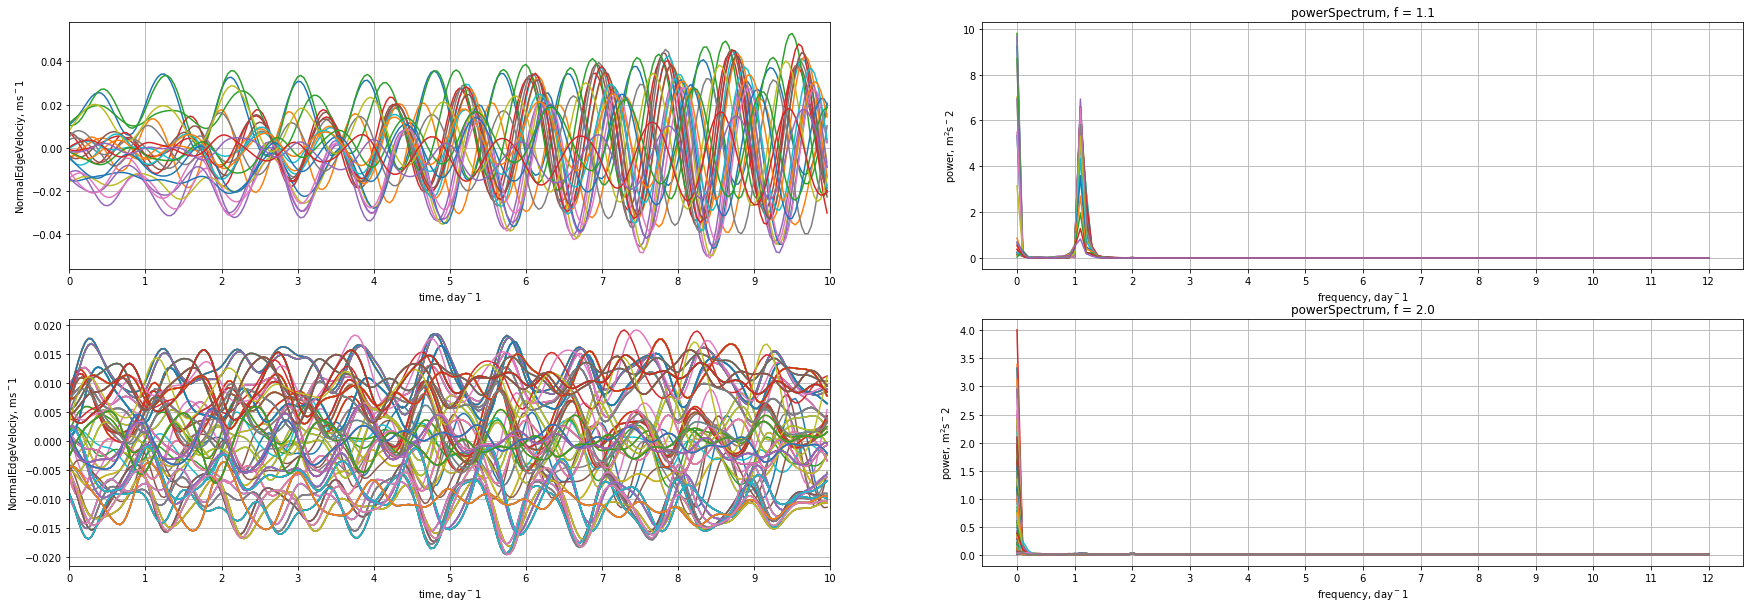

In [6]:
# Southern Boundary
# extract variables from picke file for Southern Bounday
file = 'mpasoData/section_lat34.5S_10day.pkl'
fh = open(file,'rb')
[daysSinceStartOfSim,
        dvEdge,latEdge,lonEdge,edgeSign,
        normalVelocityEdge,
        latCell,lonCell,maxLevelCell,
        velocityZonalCell,velocityMeridionalCell,vertVelocityTopCell,layerThicknessCell,
        refBottomDepth, h
        ]= pickle.load(fh)
latText = f'transect{i}: {np.round(latCell[0-5]*r2d,2)}'

# size of variables
nTime = np.size(normalVelocityEdge,0)
nVertLevels = np.size(normalVelocityEdge,2)
nEdges = len(latEdge)
nCells = len(latCell)

# unit conversions
d2r=np.pi/180.
r2d=180./np.pi
m3ps_to_Sv = 1e-6 # m^3/sec flux to Sverdrups
lonEdge = np.mod(lonEdge*r2d+180,360)-180
latEdge = latEdge*r2d
lonCell = np.mod(lonCell*r2d+180,360)-180
latCell = latCell*r2d
time = daysSinceStartOfSim[:nTime] - daysSinceStartOfSim[0]
mpl.rcParams['figure.figsize'] = (24,15) # Large figures

velSigned = normalVelocityEdge
for iTime in range(nTime):
    for k in range(nVertLevels):
        velSigned[:,:,k] = normalVelocityEdge[:,:,k]*edgeSign[:]
frequencies_k = []            
for k in range(nVertLevels):
        frequencies_e = []
        for edge in range(nEdges):
            data = velSigned[:,edge,k]
            # filter out values where all velocities are zero
            if max(abs(velSigned[:,edge, k])) == 0:
                frequencies_e.append(np.NaN)
            else:
                (power_spectrum, frequency, max_frequency) = powerspectrum(data, 24, cutoff=3)
                frequencies_e.append(max_frequency)
        frequencies_k.append(frequencies_e)
freq_arr = np.asarray(frequencies_k)

edge_outliers = np.where(freq_arr >= 1.9)

# edge timeseries
# edge velocity from 50-75 (non outliers)
plt.figure(figsize= (30,10))
plt.subplot(2,2,1)
plt.plot(time,velSigned[:,np.arange(50,75,1),35])
plt.xlabel('time, day$^-1$',fontsize=10)
plt.xlim([0,10])
plt.xticks(np.arange(0,10.1))
plt.ylabel('NormalEdgeVelociy, ms$^-1$',fontsize=10)
plt.grid()

#edge spectrum from 50-75 (non outliers)
plt.subplot(2,2,2)
for i in np.arange(50,75,1):
    data = velSigned[:,i,35]
    (power_spectrum, frequency, max_frequency) = powerspectrum(data, 24, cutoff=3)
    plt.plot(frequency,power_spectrum)
plt.title(f'powerSpectrum, f = {round(max_frequency,2)}')
plt.xlabel('frequency, day$^-1$',fontsize=10);
plt.ylabel('power, m$^2$s$^-2$',fontsize=10);
plt.xticks(range(0,13,1))
plt.grid()

# edge outliers >1.9 frequency velocity
plt.subplot(2,2,3)
plt.plot(time,velSigned[:,edge_outliers[1],35])
plt.xlabel('time, day$^-1$',fontsize=10)
plt.xlim([0,10])
plt.xticks(np.arange(0,10.1))
plt.ylabel('NormalEdgeVelociy, ms$^-1$',fontsize=10)
plt.grid()

# edge outliers >1.9 frequency power spectrum
plt.subplot(2,2,4)
for (k,edge) in zip(edge_outliers[0],edge_outliers[1]):
    data = velSigned[:,edge,k]
    (power_spectrum, frequency, max_frequency) = powerspectrum(data, 24, cutoff=3)
    plt.plot(frequency,power_spectrum)
plt.title(f'powerSpectrum, f = {round(max_frequency,2)}')
plt.xlabel('frequency, day$^-1$',fontsize=10);
plt.ylabel('power, m$^2$s$^-2$',fontsize=10);
plt.xticks(range(0,13,1))
plt.grid()

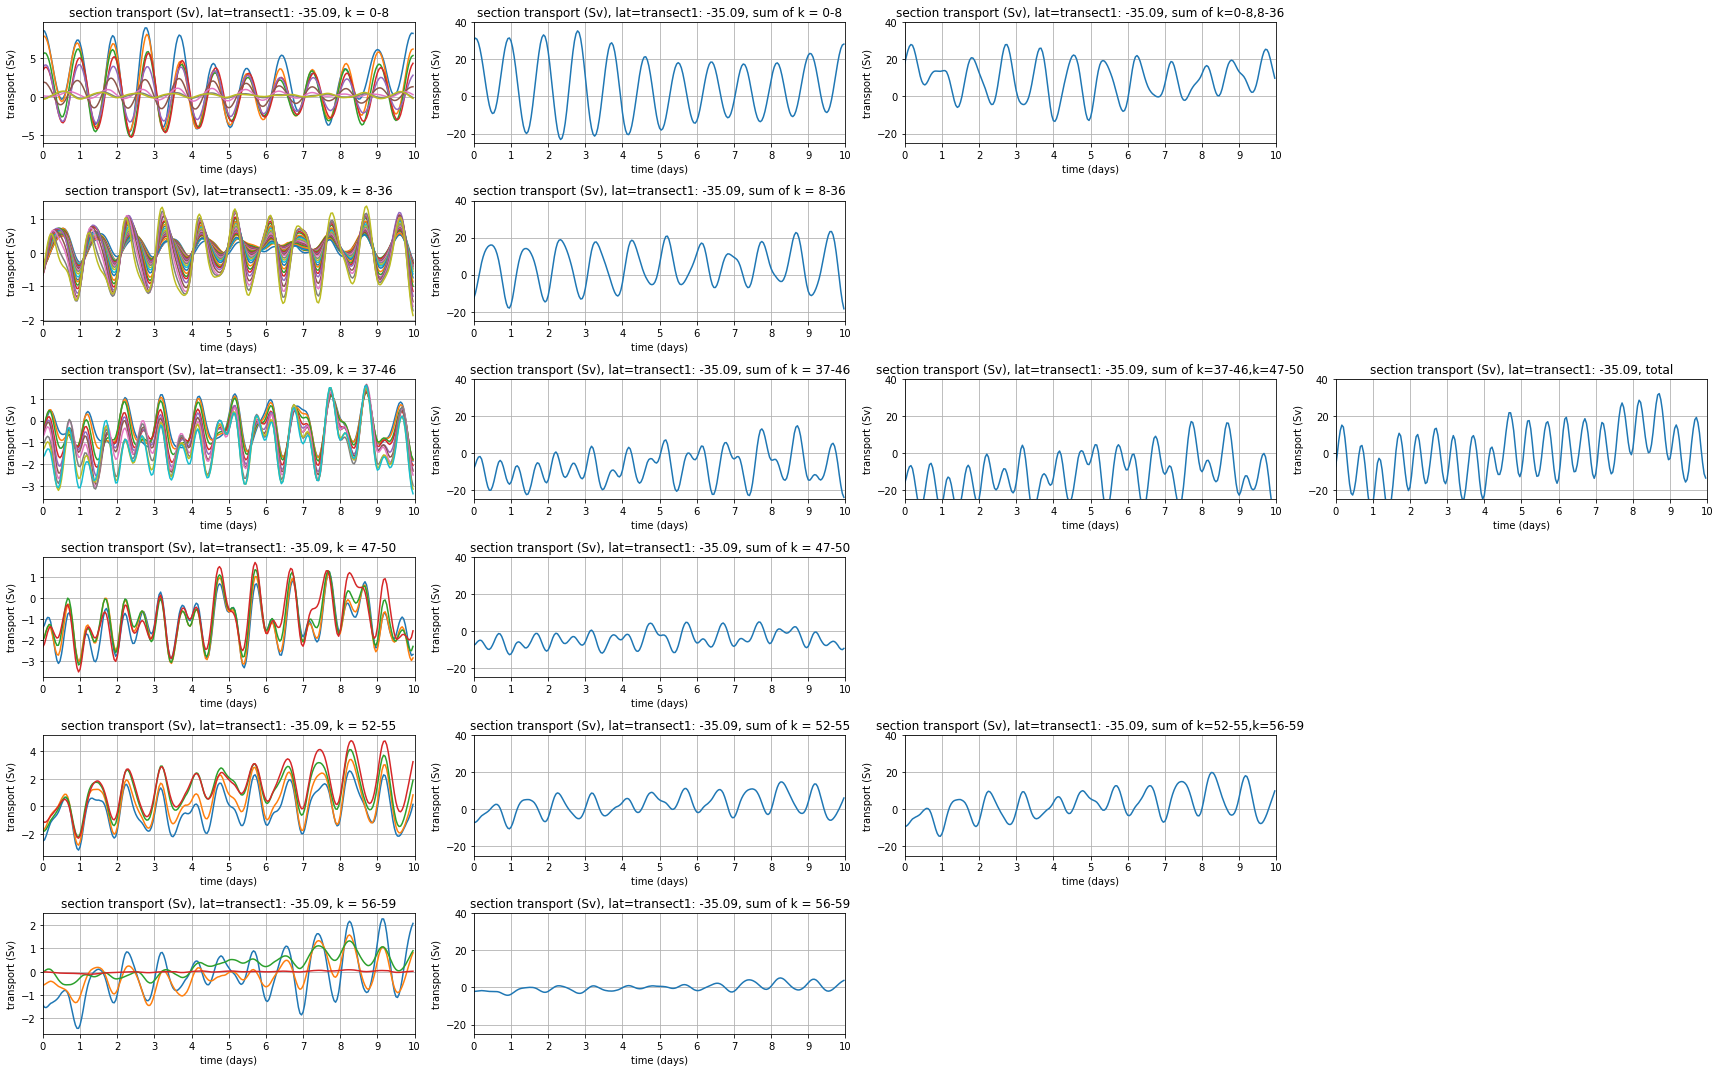

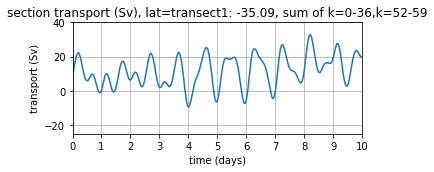

In [7]:
"Creates a large subplot breaking down the sum of the transport at the transect into individual steps"
a = 6
b = 4
# plot transport at various levels where the transport time series seem in phase
plt.subplot(a,b,1)
plt.plot(time,transportZ[:,0,0:9],)
plt.title('section transport (Sv), lat='+latText + ', k = 0-8')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

plt.subplot(a,b,5)
plt.plot(time,transportZ[:,0,8:37])
plt.title('section transport (Sv), lat='+latText + ', k = 8-36')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

plt.subplot(a,b,9)
plt.plot(time,transportZ[:,0,37:47])
plt.title('section transport (Sv), lat='+latText + ', k = 37-46')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

plt.subplot(a,b,13)
plt.plot(time,transportZ[:,0,47:51])
plt.title('section transport (Sv), lat='+latText + ', k = 47-50')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.xticks(np.arange(0,10.1))
plt.grid()

plt.subplot(a,b,17)
plt.plot(time,transportZ[:,0,52:56])
plt.title('section transport (Sv), lat='+latText + ', k = 52-55')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

plt.subplot(a,b,21)
plt.plot(time,transportZ[:,0,56:60])
plt.title('section transport (Sv), lat='+latText + ', k = 56-59')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

# plot sums of those time series
plt.subplot(a,b,2)
q = transportZ[:,0,0:9].sum(1)
plt.plot(time,q)
plt.title('section transport (Sv), lat='+latText + ', sum of k = 0-8')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.ylim([-25,40])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

plt.subplot(a,b,6)
r = transportZ[:,0,8:37].sum(1)
plt.plot(time,r)
plt.title('section transport (Sv), lat='+latText + ', sum of k = 8-36')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.ylim([-25,40])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

plt.subplot(a,b,10)
s = transportZ[:,0,37:47].sum(1)
plt.plot(time,s)
plt.title('section transport (Sv), lat='+latText + ', sum of k = 37-46')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.ylim([-25,40])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

plt.subplot(a,b,14)
t = transportZ[:,0,47:51].sum(1)
plt.plot(time,t)
plt.title('section transport (Sv), lat='+latText + ', sum of k = 47-50')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.ylim([-25,40])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

plt.subplot(a,b,18)
u = transportZ[:,0,52:56].sum(1)
plt.plot(time,u)
plt.title('section transport (Sv), lat='+latText + ', sum of k = 52-55')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.ylim([-25,40])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

plt.subplot(a,b,22)
v = transportZ[:,0,56:60].sum(1)
plt.plot(time,v)
plt.title('section transport (Sv), lat='+latText + ', sum of k = 56-59')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.ylim([-25,40])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

# plot the sums of the sums of the time series
plt.subplot(a,b,3)
w = np.add(q,r)
plt.plot(time,w)
plt.title('section transport (Sv), lat='+latText + ', sum of k=0-8,8-36')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.ylim([-25,40])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

x = np.add(s,t)
plt.subplot(a,b,11)
plt.plot(time,x)
plt.title('section transport (Sv), lat='+latText + ', sum of k=37-46,k=47-50')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.ylim([-25,40])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

plt.subplot(a,b,19)
y = np.add(u,v)
plt.plot(time,y)
plt.title('section transport (Sv), lat='+latText + ', sum of k=52-55,k=56-59')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.ylim([-25,40])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

# total
plt.subplot(a,b,12)
z = np.add(np.add(w,x),y)
plt.plot(time,z)
plt.title('section transport (Sv), lat='+latText + ', total')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.ylim([-25,40])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()

plt.savefig('transportSumat34.5SSAtlantic/Sum_of_Transports_lat34.5S.png')

# plot the sum of the two sums that seem most offphase
plt.figure(figsize = (5,2.5))
plt.plot(time,w + y)
plt.title('section transport (Sv), lat='+latText + ', sum of k=0-36,k=52-59')
plt.xlabel('time (days)')
plt.ylabel('transport (Sv)')
plt.xlim([0,10])
plt.ylim([-25,40])
plt.xticks(np.arange(0,10.1))
plt.grid()
plt.tight_layout()
plt.savefig('transportSumat34.5SSAtlantic/Sum_of_TransportPhaseOffSet')